In [ ]:
%load_ext tensorboard
import os
os.environ["TF_CPP_MIN_VLOG_LEVEL"] = "2"
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import tensorrt as trt

print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))
print("TensorRt:", trt.__version__)

RANDOM_STATE = 42

random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

TARGET = "rucwar"
MIN_PER_CLASS = 50
OUTER_SPLITS = 2
INNER_SPLITS = 2
BATCH_SIZE = 64

SAMPLE_RATE = 16000
MAX_DURATION = 10 # seconds
NEG_POS_RATIO = 3
TRAIN_NEG_RATIO = 2
VAL_NEG_RATIO = 2
FILL_TYPE = "pad" # pad | tile
N_MELS = 128
N_FRAMES = 157
FRAME_OVERLAP = int(np.ceil(N_FRAMES * 0.5))

SECONDS = 5
BYTES_PER_SECOND = SECONDS * SAMPLE_RATE
INPUT_SHAPE = (N_MELS, N_FRAMES, 1)

2025-09-01 12:33:47.794724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TF: 2.20.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorRt: 10.13.2.6


In [2]:
from sklearn.model_selection import StratifiedGroupKFold
import os
import librosa

# birdclef sanity checks
def sanity_birdlcef(df: pd.DataFrame, target: str):
    # File integrity
    for r in df.itertuples():
        if os.path.isfile(r.path) is not True:
            print(f"[ERROR]: {r.path} is not valid!")
    
    # Dupicates
    dups = df['path'].duplicated().sum()  # or 'filename'
    print("Duplicate file rows:", dups)
    
    # Count summary
    print(f"Total Positives: {df[df['primary_label'] == target].shape[0]}")
    print(f"Total Negatives: {df[df['primary_label'] != target].shape[0]}")
    print(f"Avg samples per Class: {df['primary_label'].value_counts().mean():.0f}")



# Different functions for each dataset
def load_birdclef(audio_root, path, target, min_per_class = MIN_PER_CLASS):
    df = pd.read_csv(path)
    
    df["path"] = audio_root + "/" + df["primary_label"] + "/" + df["filename"]
    
    # Optional: drop rare classes (keeps CV stable)
    if min_per_class > 1:
        keep_labels = df["primary_label"].value_counts()
        keep_labels = keep_labels[keep_labels >= min_per_class].index
        df = df[df["primary_label"].isin(keep_labels)].reset_index(drop=True)
    
    # Perform sanity checks
    sanity_birdlcef(df, target)

    # Generate the binary labels, target = 1 else 0
    labels = (df['primary_label'] == target).astype(int).values
    
    # Group based on auther + time te prevent straddeling
    df["group_key"] = df["author"] + df["time"]
    
    return df
    

os.chdir("/home/joris/Thesis/new_attempt")

birdclef_df = load_birdclef("datasets/birdclef_2021/train_short_audio", "datasets/birdclef_2021/train_metadata.csv", target=TARGET)


Duplicate file rows: 0
Total Positives: 154
Total Negatives: 61815
Avg samples per Class: 168


In [3]:
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import pandas as pd

def make_nested_cv_splits(
    df: pd.DataFrame,
    target: str = TARGET,
    outer_splits: int = OUTER_SPLITS,
    inner_splits: int = INNER_SPLITS,
    random_state: int = RANDOM_STATE,
):
    """
    Build nested CV folds for binary BirdCLEF: target species = 1, others = 0.
    Uses StratifiedGroupKFold for both outer and inner splits to avoid leakage across groups.
    """
    
    # Binary labels for stratification
    y_all = (df["primary_label"] == target).astype(int).values
    groups_all = df["group_key"].astype(str).fillna("NA").values
    idx_all = np.arange(len(df))

    outer_kf = StratifiedGroupKFold(n_splits=outer_splits, shuffle=True, random_state=random_state)

    nested = []
    for k, (outer_tr_idx, outer_te_idx) in enumerate(outer_kf.split(idx_all, y=y_all, groups=groups_all), start=1):
        # Outer train/val pool and test set
        trval_idx = idx_all[outer_tr_idx]
        test_idx  = idx_all[outer_te_idx]

        y_trval   = y_all[outer_tr_idx]
        groups_trval = groups_all[outer_tr_idx]

        # Inner CV on the outer train/val pool
        inner_kf = StratifiedGroupKFold(n_splits=inner_splits, shuffle=True, random_state=random_state)
        inner_folds = []
        for j, (inner_tr_rel, inner_va_rel) in enumerate(inner_kf.split(trval_idx, y=y_trval, groups=groups_trval), start=1):
            # Map relative indices back to global indices
            inner_tr_idx = trval_idx[inner_tr_rel]
            inner_va_idx = trval_idx[inner_va_rel]

            inner_folds.append({
                "inner_fold": j,
                "inner_train_idx": inner_tr_idx,
                "inner_val_idx":   inner_va_idx,
            })

        nested.append({
            "outer_fold": k,
            "outer_train_idx": trval_idx,
            "outer_test_idx":  test_idx,
            "inner_folds": inner_folds,
            "train_pos_ratio": float(y_all[outer_tr_idx].mean()),
            "test_pos_ratio":  float(y_all[outer_te_idx].mean()),
        })

    return nested

    
    
cross_validation_sets = make_nested_cv_splits(birdclef_df)

In [4]:
import tensorflow_io as tfio
import subprocess

def load_ogg_ffmpeg(path, sr=16000):
    path = path.decode("utf-8")
    cmd = [
        "ffmpeg", "-i", path, "-f", "f32le",
        "-ac", "1", "-ar", str(sr), "pipe:1", "-loglevel", "quiet"
    ]
    out = subprocess.check_output(cmd)
    audio = np.frombuffer(out, np.float32)
    return audio

def load_ogg_librosa(path, sr=16000):
    path = path.decode("utf-8")
    y, sr = librosa.load(path, sr=SAMPLE_RATE)
    return y


def audio_pipeline(filename, augment=False, gaussian=0):
    # Load audio file as tensor 
    # audio_file = tf.numpy_function(load_ogg_ffmpeg, [filename, SAMPLE_RATE], tf.float32)
    audio_file = tf.numpy_function(load_ogg_librosa, [filename, SAMPLE_RATE], tf.float32)
    # audio_file, sr = librosa.load(filename.numpy(), sr=SAMPLE_RATE)
    
    # Remove last dimension
    waveform = audio_file[:SAMPLE_RATE * MAX_DURATION]
    
    if False:
        # Trim the noise from the audio
        position = tfio.audio.trim(waveform, axis=0, epsilon=0.1, name="Trim")
        
        start = position[0]
        stop = position[1]

        processed = waveform[start:stop]
    else:
        processed = waveform[:SAMPLE_RATE * SECONDS]
        
    # if gaussian > 0:
    #     processed = aug_gaussian_noise_snr(processed, gaussian)
    
    frame_count = tf.shape(processed)
    # Calculate end padding
    if (frame_count < SAMPLE_RATE):
        processed = waveform
        frame_count = tf.shape(processed)
    
    if FILL_TYPE == "pad":
        padding = tf.maximum(0, (SAMPLE_RATE * SECONDS) - frame_count[0])
        processed = tf.pad(processed, paddings=[[padding, 0]], name="Padding")
    elif FILL_TYPE == "tile":
        repeats = tf.maximum(tf.cast(1, tf.int64), 1 + tf.cast(((SAMPLE_RATE * SECONDS) / frame_count), tf.int64))
        
        processed = tf.repeat(processed, repeats)
        # Reduce size to max 
        processed = processed[:SAMPLE_RATE * SECONDS]
        
    if augment:
        # Fade in and out
        fade = tfio.audio.fade(
            processed, fade_in=1000, fade_out=2000, mode="logarithmic", name="Fade")
    else:
        fade = processed
    
    # Band filter
    from scipy import signal
    b, a = signal.butter(4, [200, 7999], fs=SAMPLE_RATE, btype='band')
    band_filter = tf.py_function(signal.lfilter, [b, a, fade], Tout=tf.float32, name="Filter")

    spectrogram = tfio.audio.spectrogram(band_filter, nfft=1024, window=512, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=SAMPLE_RATE, mels=N_MELS, fmin=20, fmax=8000)
    db_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
    
    db_mel_spectrogram = tf.expand_dims(db_mel_spectrogram, -1)
    
    db_mel_spectrogram = tf.transpose(db_mel_spectrogram, perm=[1, 0 ,2])
    
    # db_mel_spectrogram = tf.ensure_shape(db_mel_spectrogram, (128, 188, 1))
    
    return db_mel_spectrogram

/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutex6unlockEv']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/home/joris/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tensorfl

In [5]:
import tensorflow as tf

# --------- Simple binary CNN ----------
def build_binary_cnn(
    input_shape=(128, 64, 1),
    lr=1e-3,
    l2=1e-4,
    dropout=0.25,
    gamma=2.0,
    alpha=0.25,
):
    """
    Binary classifier for log-mel spectrograms (target vs non-target).
    Output: single sigmoid unit.
    Loss: Binary Focal Cross-Entropy (with safe fallbacks).
    """
    L2 = tf.keras.regularizers.l2(l2)
    Conv = tf.keras.layers.Conv2D

    inputs = tf.keras.Input(shape=input_shape)

    # Block 1
    x = Conv(32, (3, 3), padding="same", kernel_regularizer=L2)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv(32, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 128x64 -> 64x32
    x = tf.keras.layers.Dropout(dropout)(x)

    # Block 2
    x = Conv(64, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv(64, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 64x32 -> 32x16
    x = tf.keras.layers.Dropout(dropout)(x)

    # Block 3
    x = Conv(96, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Conv(96, (3, 3), padding="same", kernel_regularizer=L2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)   # 32x16 -> 16x8
    x = tf.keras.layers.Dropout(dropout)(x)

    # Head
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=L2)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)  # binary

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryFocalCrossentropy(
            alpha=alpha,
            gamma=gamma,
            name='binary_focal_crossentropy'
        ),
        metrics=[
            tf.keras.metrics.MeanSquaredError(name='Brier score'),
            tf.keras.metrics.BinaryAccuracy(name="acc", threshold=0.5),
            tf.keras.metrics.AUC(curve="ROC", name="auc"),
            tf.keras.metrics.AUC(curve="PR",  name="auprc"),
            tf.keras.metrics.Precision(name="precision", thresholds=0.5),
            tf.keras.metrics.Recall(name="recall", thresholds=0.5),
        ],
    )
    return model


In [6]:
import random
from typing import Sequence, Optional, Tuple

def _map_pos(x, y):
    return audio_pipeline(x, augment=True), y

def _map_neg(x, y):
    return audio_pipeline(x, augment=True), y

def plan_epoch_counts(n_pos_train: int, neg_pos_ratio: float = 2.0) -> Tuple[int, int]:
    P_pos = int(n_pos_train)               # see each positive once per epoch
    P_neg = int(round(neg_pos_ratio * P_pos))
    return P_pos, P_neg 

def sample_train_negatives(neg_all: Sequence[str], n_neg: int, seed: Optional[int] = None) -> Sequence[str]:
    n = min(n_neg, len(neg_all))
    rng = random.Random(seed)
    return rng.sample(list(neg_all), n) if n > 0 else []

def make_fixed_val_negatives(neg_all: Sequence[str], n_pos_val: int, neg_pos_ratio: int = NEG_POS_RATIO, seed: int = RANDOM_STATE) -> Sequence[str]:
    n_neg = min(neg_pos_ratio * n_pos_val, len(neg_all))
    rng = random.Random(seed)
    return rng.sample(list(neg_all), n_neg) if n_neg > 0 else []

def build_train_dataset(pos_files: Sequence[str], neg_files: Sequence[str], batch_size: int = BATCH_SIZE, shuffle: bool = True) -> tf.data.Dataset:
    labels_pos = tf.ones([len(pos_files)], dtype=tf.float32)
    labels_neg = tf.zeros([len(neg_files)], dtype=tf.float32)
    
    ds_pos = tf.data.Dataset.from_tensor_slices((list(pos_files), labels_pos)).map(_map_pos, num_parallel_calls=10)
    ds_neg = tf.data.Dataset.from_tensor_slices((list(neg_files), labels_neg)).map(_map_neg, num_parallel_calls=10)

    ds = ds_pos.concatenate(ds_neg)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(pos_files) + len(neg_files), seed=RANDOM_STATE, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).cache().repeat()
    return ds


def build_val_dataset(pos_files: Sequence[str], neg_files_fixed: Sequence[str], batch_size: int = BATCH_SIZE) -> tf.data.Dataset:
    y_pos = tf.ones([len(pos_files)],        dtype=tf.float32)
    y_neg = tf.zeros([len(neg_files_fixed)], dtype=tf.float32)

    ds_pos = tf.data.Dataset.from_tensor_slices((list(pos_files), y_pos)).map(lambda x,y: (audio_pipeline(x, augment=False), y), num_parallel_calls=10)
    ds_neg = tf.data.Dataset.from_tensor_slices((list(neg_files_fixed), y_neg)).map(lambda x,y: (audio_pipeline(x, augment=False), y), num_parallel_calls=10)

    return ds_pos.concatenate(ds_neg).batch(batch_size).cache()

def build_file_lists(df: pd.DataFrame, idx, target=TARGET):
    sub = df.iloc[idx]
    pos = sub[sub.primary_label == target]["path"].tolist()
    neg = sub[sub.primary_label != target]["path"].tolist()
    return pos, neg

def make_epoch_train_dataset(pos_tr_all: Sequence[str], neg_tr_all: Sequence[str],
                             neg_pos_ratio: float = 2.0, batch_size: int = BATCH_SIZE, seed: Optional[int] = RANDOM_STATE) -> tf.data.Dataset:
    P_pos, P_neg = plan_epoch_counts(len(pos_tr_all), neg_pos_ratio)
    neg_epoch = sample_train_negatives(neg_tr_all, P_neg, seed=seed)
    return build_train_dataset(pos_tr_all, neg_epoch, batch_size=batch_size, shuffle=True)

def make_fixed_val_dataset(pos_va_all: Sequence[str], neg_va_all: Sequence[str],
                           neg_pos_ratio: int = 3, batch_size: int = BATCH_SIZE, seed: int = RANDOM_STATE) -> tf.data.Dataset:
    neg_fixed = make_fixed_val_negatives(neg_va_all, len(pos_va_all), neg_pos_ratio=neg_pos_ratio, seed=seed)
    return build_val_dataset(pos_va_all, neg_fixed, batch_size=batch_size)


def build_all_file_lists(df: pd.DataFrame, folds: dict, epoch: int = 0):
    out = []
    for fold in folds:
        outer_fold = int(fold["outer_fold"])
        outer_train_idx = fold["outer_train_idx"]
        outer_test_idx = fold["outer_test_idx"]
    
        # Build the file lists for the outer fold
        pos_tr_all, neg_tr_all = build_file_lists(df, outer_train_idx)    
        pos_test_all, neg_test_all = build_file_lists(df, outer_test_idx)
    

        # Rotate negatives each epoch via seed that depends on (outer, inner, epoch)
        outer_train_ds = make_epoch_train_dataset(
            pos_tr_all,
            neg_tr_all,
            neg_pos_ratio=TRAIN_NEG_RATIO,
            batch_size=BATCH_SIZE,
            seed=outer_fold,
        )

        outer_test_ds = make_fixed_val_dataset(
            pos_test_all,
            neg_test_all,
            neg_pos_ratio=VAL_NEG_RATIO,
            batch_size=BATCH_SIZE,
            seed=outer_fold,  # fixed per outer fold
        )
    
        
        inner_list = []
        for inner in fold["inner_folds"]:
            inner_fold = int(inner["inner_fold"])
            inner_train_idx = inner["inner_train_idx"]
            inner_val_idx   = inner["inner_val_idx"]

            pos_tr_all, neg_tr_all = build_file_lists(df, inner_train_idx)
            pos_va_all, neg_va_all = build_file_lists(df, inner_val_idx)

            # Rotate negatives each epoch via seed that depends on (outer, inner, epoch)
            train_ds = make_epoch_train_dataset(
                pos_tr_all,
                neg_tr_all,
                neg_pos_ratio=TRAIN_NEG_RATIO,
                batch_size=BATCH_SIZE,
                seed=outer_fold * 100_000 + inner_fold * 1_000 + epoch,
            )

            # Fixed validation and test datasets (reproducible seeds per outer/inner)
            val_ds = make_fixed_val_dataset(
                pos_va_all,
                neg_va_all,
                neg_pos_ratio=VAL_NEG_RATIO,
                batch_size=BATCH_SIZE,
                seed=outer_fold * 100_000 + inner_fold,
            )

            test_ds = make_fixed_val_dataset(
                pos_test_all,
                neg_test_all,
                neg_pos_ratio=VAL_NEG_RATIO,
                batch_size=BATCH_SIZE,
                seed=outer_fold,  # fixed per outer fold
            )

            inner_list.append({
                "inner_fold": inner_fold,
                "train_ds": train_ds,
                "val_ds":   val_ds,
                "test_ds":  test_ds,
            })
        out.append({"outer_fold": outer_fold, "train_ds":outer_train_ds, "test_ds":outer_test_ds, "inner": inner_list})
    return out
        

datasets = build_all_file_lists(birdclef_df, cross_validation_sets)

I0000 00:00:1756722836.030076    1547 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9509 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
per_fold_results = []

EPOCHS_PER_FOLD = 50

hparams_per_fold = {
    0: {"lr":1e-3, "gamma":1.0, "alpha":0.25},
    1: {"lr":1e-3, "gamma":2.0, "alpha":0.5},
    2: {"lr":1e-3, "gamma":3.0, "alpha":0.75},
    3: {"lr":1e-3, "gamma":4.0, "alpha":0.25},
    4: {"lr":1e-3, "gamma":5.0, "alpha":0.25},
}

for outer_fold in datasets:
    print(f"[INFO]: Running outer fold: {outer_fold["outer_fold"]}")
    inner_scores = []
    for inner_fold in outer_fold["inner"]:
        print(f"[INFO]: Running inner fold: {inner_fold["inner_fold"]}")
        model = build_binary_cnn(input_shape=INPUT_SHAPE, 
                                 lr=hparams_per_fold[inner_fold["inner_fold"]]["lr"], 
                                 gamma=hparams_per_fold[inner_fold["inner_fold"]]["gamma"], 
                                 alpha=hparams_per_fold[inner_fold["inner_fold"]]["alpha"])

        model.fit(
            inner_fold["train_ds"],
            epochs = EPOCHS_PER_FOLD,
            validation_data=inner_fold["val_ds"],
            steps_per_epoch=8,
            verbose=1
        )
        
        
        vals = model.evaluate(inner_fold["test_ds"], verbose=0)
        print(model.metrics_names)
        print(vals)
        inner_scores.append(vals[2])
    
    mean_test_acc = np.mean(inner_scores)
    print(f"Inner CV mean test acc: {mean_test_acc:.3f}")
    
    # Retrain with the best parameters
    best_inner = np.argmax(inner_scores)
    
    model = build_binary_cnn(input_shape=INPUT_SHAPE, 
                                lr=hparams_per_fold[best_inner]["lr"], 
                                gamma=hparams_per_fold[best_inner]["gamma"], 
                                alpha=hparams_per_fold[best_inner]["alpha"])
    model.fit(
        outer_fold["train_ds"],
        epochs = EPOCHS_PER_FOLD,
        steps_per_epoch=8,
        verbose=1
    )
    
    vals = model.evaluate(outer_fold["test_ds"], verbose=0)
    per_fold_results.append(vals[2])

print(per_fold_results)

[INFO]: Running outer fold: 1
[INFO]: Running inner fold: 1
Epoch 1/50


2025-09-01 12:34:10.838067: I external/local_xla/xla/service/service.cc:163] XLA service 0x78953008a150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-01 12:34:10.838105: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-09-01 12:34:10.938251: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-01 12:34:11.396361: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-09-01 12:34:11.651997: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:34:11.

2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - Brier score: 0.2097 - acc: 0.6797 - auc: 0.5993 - auprc: 0.3801 - loss: 0.2243 - precision: 0.7000 - recall: 0.2199

2025-09-01 12:34:29.320436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 12 bytes spill stores, 12 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 939ms/step - Brier score: 0.2260 - acc: 0.6247 - auc: 0.5651 - auprc: 0.3619 - loss: 0.2294 - precision: 0.4483 - recall: 0.2686

2025-09-01 12:34:37.833109: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - Brier score: 0.2349 - acc: 0.5944 - auc: 0.5477 - auprc: 0.3725 - loss: 0.2276 - precision: 0.3821 - recall: 0.3615 - val_Brier score: 0.3080 - val_acc: 0.6667 - val_auc: 0.5000 - val_auprc: 0.4289 - val_loss: 1.4263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - Brier score: 0.2305 - acc: 0.6446 - auc: 0.5441 - auprc: 0.3847 - loss: 0.2118 - precision: 0.4179 - recall: 0.2617 - val_Brier score: 0.3277 - val_acc: 0.6667 - val_auc: 0.5439 - val_auprc: 0.4495 - val_loss: 3.0440 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - Brier score: 0.2330 - acc: 0.6114 - auc: 0.5884 - auprc: 0.3913 - loss: 0.2097 - precision: 0.4167 - recall: 0.3043 - val_Brier score: 0.3312 - val_acc: 0.6667 - val_auc: 0.5625 - val_auprc: 0.4536 - val_loss: 4.0418 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/ste

2025-09-01 12:35:18.880847: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


['loss', 'compile_metrics']
[0.483369916677475, 0.2183903455734253, 0.7095237970352173, 0.766428530216217, 0.6665261387825012, 0.550561785697937, 0.699999988079071]
[INFO]: Running inner fold: 2
Epoch 1/50
1/8 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - Brier score: 0.2965 - acc: 0.6406 - auc: 0.4708 - auprc: 0.3342 - loss: 0.6642 - precision: 0.0000e+00 - recall: 0.0000e+00

2025-09-01 12:35:27.889097: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:35:27.889139: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:35:28.132015: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 12 bytes spill stores, 12 bytes spill loads

2025-09-01 12:35:28.367545: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - Brier score: 0.2678 - acc: 0.5562 - auc: 0.4898 - auprc: 0.3268 - loss: 0.2640 - precision: 0.3520 - recall: 0.3938 - val_Brier score: 0.2524 - val_acc: 0.6667 - val_auc: 0.3955 - val_auprc: 0.3065 - val_loss: 0.3258 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - Brier score: 0.2373 - acc: 0.6062 - auc: 0.5387 - auprc: 0.3746 - loss: 0.1406 - precision: 0.3840 - recall: 0.3000 - val_Brier score: 0.2935 - val_acc: 0.6591 - val_auc: 0.3933 - val_auprc: 0.2816 - val_loss: 0.8181 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - Brier score: 0.2350 - acc: 0.6083 - auc: 0.5645 - auprc: 0.3858 - loss: 0.1309 - precision: 0.3793 - recall: 0.2750 - val_Brier score: 0.3461 - val_acc: 0.3333 - val_auc: 0.5702 - val_auprc: 0.3644 - val_loss: 0.3239 - val_precision: 0.3333 - val_recall: 1.0000
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - Bri

2025-09-01 12:36:44.712593: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:36:44.712646: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:36:44.712656: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:36:45.025641: I external/l

8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - Brier score: 0.2490 - acc: 0.6012 - auc: 0.4621 - auprc: 0.3069 - loss: 0.4283 - precision: 0.3059 - recall: 0.1548
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - Brier score: 0.2244 - acc: 0.6369 - auc: 0.5884 - auprc: 0.3961 - loss: 0.3640 - precision: 0.3973 - recall: 0.1726
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - Brier score: 0.2235 - acc: 0.6706 - auc: 0.5964 - auprc: 0.4157 - loss: 0.3644 - precision: 0.5263 - recall: 0.1190
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - Brier score: 0.2203 - acc: 0.6786 - auc: 0.6108 - auprc: 0.4407 - loss: 0.3538 - precision: 0.5625 - recall: 0.1607
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - Brier score: 0.2074 - acc: 0.6905 - auc: 0.6962 - auprc: 0.5293 - loss: 0.3342 - precision: 0.7308 - recall: 0.1131
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - Brier score: 0.1986 - acc: 0.7202 - auc: 0.7691 - auprc: 0.6325 - loss: 0.3172 - precision: 0.7143 - recall: 0.2679
Epoch

2025-09-01 12:37:59.103761: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:37:59.103831: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:37:59.424078: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 12 bytes spill stores, 12 bytes spill loads

2025-09-01 12:37:59.622704: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Brier score: 0.2609 - acc: 0.5582 - auc: 0.5719 - auprc: 0.4025 - loss: 0.3042 - precision: 0.3996 - recall: 0.5589

2025-09-01 12:38:10.562723: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - Brier score: 0.2416 - acc: 0.6023 - auc: 0.5670 - auprc: 0.3854 - loss: 0.2617 - precision: 0.3986 - recall: 0.3904 - val_Brier score: 0.2816 - val_acc: 0.6667 - val_auc: 0.3951 - val_auprc: 0.3012 - val_loss: 0.8133 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - Brier score: 0.2167 - acc: 0.6955 - auc: 0.6799 - auprc: 0.5089 - loss: 0.2017 - precision: 0.5851 - recall: 0.3957 - val_Brier score: 0.3153 - val_acc: 0.6667 - val_auc: 0.4383 - val_auprc: 0.3016 - val_loss: 1.7645 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - Brier score: 0.2105 - acc: 0.7005 - auc: 0.6950 - auprc: 0.5084 - loss: 0.1939 - precision: 0.5556 - recall: 0.3817 - val_Brier score: 0.3101 - val_acc: 0.6852 - val_auc: 0.4406 - val_auprc: 0.3464 - val_loss: 2.1383 - val_precision: 1.0000 - val_recall: 0.0556
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - Bri

2025-09-01 12:39:00.506186: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:39:00.506237: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:39:00.696816: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 12 bytes spill stores, 12 bytes spill loads

2025-09-01 12:39:00.957548: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning :

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 639ms/step - Brier score: 0.2197 - acc: 0.6435 - auc: 0.6343 - auprc: 0.5215 - loss: 0.1493 - precision: 0.4615 - recall: 0.4167 - val_Brier score: 0.6183 - val_acc: 0.3333 - val_auc: 0.6616 - val_auprc: 0.4446 - val_loss: 2.7544 - val_precision: 0.3333 - val_recall: 1.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - Brier score: 0.2050 - acc: 0.7130 - auc: 0.7159 - auprc: 0.6273 - loss: 0.1192 - precision: 0.5806 - recall: 0.5000 - val_Brier score: 0.6537 - val_acc: 0.3333 - val_auc: 0.5795 - val_auprc: 0.3777 - val_loss: 5.4650 - val_precision: 0.3333 - val_recall: 1.0000
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - Brier score: 0.1958 - acc: 0.7546 - auc: 0.7600 - auprc: 0.6724 - loss: 0.1117 - precision: 0.6792 - recall: 0.5000 - val_Brier score: 0.6542 - val_acc: 0.3333 - val_auc: 0.5745 - val_auprc: 0.3748 - val_loss: 5.8517 - val_precision: 0.3333 - val_recall: 1.0000
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - Brier score: 0.1

2025-09-01 12:40:11.836033: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-01 12:40:12.018765: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 12 bytes spill stores, 12 bytes spill loads

2025-09-01 12:40:12.158347: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3900', 16 bytes spill stores, 16 bytes spill loads



8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - Brier score: 0.2446 - acc: 0.6190 - auc: 0.5064 - auprc: 0.3647 - loss: 0.4458 - precision: 0.3810 - recall: 0.2286
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - Brier score: 0.2220 - acc: 0.6714 - auc: 0.5791 - auprc: 0.4354 - loss: 0.3672 - precision: 0.5179 - recall: 0.2071
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - Brier score: 0.2196 - acc: 0.6690 - auc: 0.6061 - auprc: 0.4334 - loss: 0.3644 - precision: 0.5116 - recall: 0.1571
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - Brier score: 0.2122 - acc: 0.6738 - auc: 0.6490 - auprc: 0.4720 - loss: 0.3506 - precision: 0.5385 - recall: 0.1500 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - Brier score: 0.2088 - acc: 0.6976 - auc: 0.6678 - auprc: 0.5222 - loss: 0.3428 - precision: 0.6585 - recall: 0.1929 
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - Brier score: 0.2028 - acc: 0.7000 - auc: 0.7240 - auprc: 0.5585 - loss: 0.3325 - precision: 0.6207 - recall: 0.2571 
Epoch

In [10]:
# Now we can train the actual model we use for the soundscapes based on the best configuration

model = build_binary_cnn(input_shape=INPUT_SHAPE, 
                         lr=hparams_per_fold[best_inner]["lr"], 
                         gamma=hparams_per_fold[best_inner]["gamma"], 
                         alpha=hparams_per_fold[best_inner]["alpha"])
model.fit(
    datasets[np.argmax(per_fold_results)]["train_ds"],
    epochs = EPOCHS_PER_FOLD,
    steps_per_epoch=8,
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - Brier score: 0.2496 - acc: 0.5992 - auc: 0.4841 - auprc: 0.3119 - loss: 0.4297 - precision: 0.3455 - recall: 0.2262
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - Brier score: 0.2244 - acc: 0.6706 - auc: 0.5698 - auprc: 0.4228 - loss: 0.3720 - precision: 0.5143 - recall: 0.2143
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - Brier score: 0.2179 - acc: 0.6746 - auc: 0.6156 - auprc: 0.4642 - loss: 0.3541 - precision: 0.5400 - recall: 0.1607
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - Brier score: 0.2138 - acc: 0.6786 - auc: 0.6653 - auprc: 0.4703 - loss: 0.3458 - precision: 0.5577 - recall: 0.1726
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - Brier score: 0.2072 - acc: 0.7004 - auc: 0.7148 - auprc: 0.5488 - loss: 0.3318 - precision: 0.6667 - recall: 0.2024
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - Brier score: 0.1931 - acc: 0.7421 - auc: 0.7948 - auprc: 0.6973 - loss: 0.3089 - precision: 0.7879 - recall

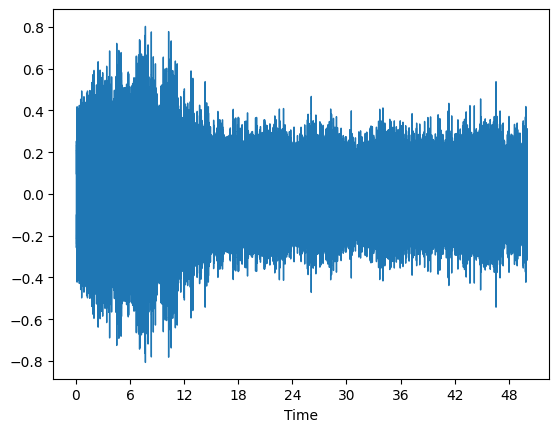

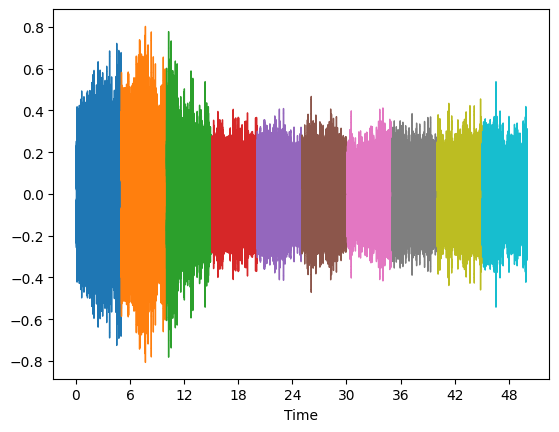

In [43]:
import math
import matplotlib.pyplot as plt

# Load a soundscape
# y, sr = librosa.load("datasets/birdclef_2021/train_soundscapes/18003_COR_20190904.ogg", sr=SAMPLE_RATE)
y, sr = librosa.load("datasets/birdclef_2021/train_soundscapes/21767_COR_20190904.ogg", sr=SAMPLE_RATE)

# Filter for the current file
CURRENT_SITE = "COR"
CURRENT_ID = 21767

# Cut it into chunks of BYTES_PER_SECOND
chunks = []
for i in range(0, math.ceil(len(y)/BYTES_PER_SECOND)):
    chunk = y[i*BYTES_PER_SECOND:(i+1)*BYTES_PER_SECOND]
    chunks.append(chunk)
    
count = 10
librosa.display.waveshow(y[:count*BYTES_PER_SECOND], sr=SAMPLE_RATE)
plt.show()

for i in range(count):
    librosa.display.waveshow(chunks[i], offset=i*SECONDS, sr=SAMPLE_RATE)
    
plt.show()
# Listen to the first sample
import IPython.display
IPython.display.Audio(chunks[0], rate=SAMPLE_RATE)

(128, 157)


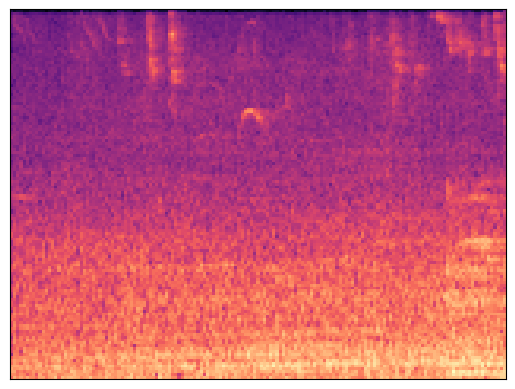

In [44]:
from librosa._typing import _STFTPad

def generate_mel_spectrogram(audio, sr = SAMPLE_RATE, n_fft=1024, n_mels=128, hop_length=512, win_length=None, 
                       window:str='hann', center=True, pad_mode:_STFTPad='constant', power=2.0, fmin=200, 
                       fmax=8000, norm='slaney'):
    # Generate mel spectrogram
    spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, n_mels=n_mels, hop_length=hop_length, win_length=win_length, window=window, center=center, pad_mode=pad_mode, power=power, fmin=fmin, fmax=fmax, norm=norm)
    # Convert to dB
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec

# Convert the chunks into spectrograms
for i, chunk in enumerate(chunks):
    chunks[i] = generate_mel_spectrogram(chunk)

print(chunks[i].shape)
    
plt.show()
librosa.display.specshow(chunks[0])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
0.09 at 0.6083333333333333


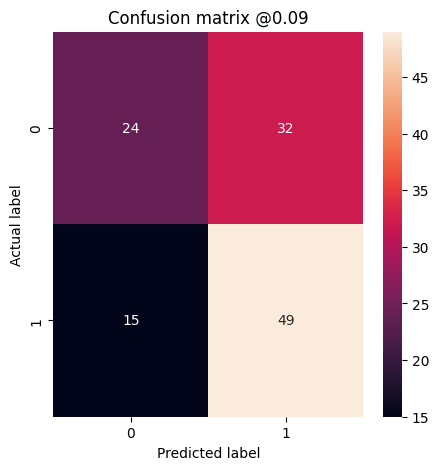

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the labels
soundscape_labels = pd.read_csv("datasets/birdclef_2021/train_soundscape_labels.csv")

soundscape_labels = soundscape_labels[(soundscape_labels["site"] == CURRENT_SITE) & (soundscape_labels["audio_id"] == CURRENT_ID)]

chunks = np.array(chunks)
# Predict the labels with the model
predictions = model.predict(chunks)

soundscape_labels["class"] = soundscape_labels["birds"].apply(lambda x: "target" if TARGET in x else "other")
soundscape_labels["predictions"] = predictions

soundscape_labels.to_csv("Soundscape_Predictions.csv")

def plot_cm(df: pd.DataFrame, threshold=0.1):
    labels = df["predictions"].apply(lambda x: "target" if x > threshold else "other")
    cm = confusion_matrix(df["class"], labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
  
max_thres = 0
max_val = -1
for t in np.arange(0.01, 1.0, 0.01):
    # Threshold tuning
    soundscape_labels["label"] = soundscape_labels["predictions"].apply(lambda x: "target" if x > t else "other")
    # Calculate accuracy
    correct = (soundscape_labels["label"] == soundscape_labels["class"]).mean()
    if (correct > max_val):
        max_val = correct
        max_thres = t
    
print(f"{max_thres} at {max_val}")
plot_cm(soundscape_labels, threshold=max_thres)